In [142]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fuzzy matching
from thefuzz import process


In [143]:
outfield_df = pd.read_csv("preprocessed_data/outfield_unique.csv")

In [144]:
FEATURE_IMPORTANT_THRESHOLD = 0.005

Feature Engineering

In [145]:
# Compute the Goals per Expected Goals Ratio
outfield_df["Finishing_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Goals - xG"]

# Handle cases where xG is zero (avoid division by zero)
outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
outfield_df["Finishing_Efficiency"] = outfield_df["Finishing_Efficiency"].replace(np.inf, 0)

# Drop Per90_Goals - xG
outfield_df = outfield_df.drop(columns=["Per90_Goals - xG"])

# Compute the Assists per Expected Assists Ratio
outfield_df["Assist_Efficiency"] = outfield_df["Per90_Assists"] / outfield_df["Per90_xA: Expected Assists"]
outfield_df["Assist_Efficiency"].fillna(0, inplace=True)
outfield_df["Assist_Efficiency"] = outfield_df["Assist_Efficiency"].replace(np.inf, 0)
outfield_df = outfield_df.drop(columns=["Per90_xA: Expected Assists"])

# Compute Shot Efficiency (Goals per Shot)
outfield_df["Shot_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Shots Total"]
outfield_df["Shot_Efficiency"].fillna(0, inplace=True)
outfield_df["Shot_Efficiency"] = outfield_df["Shot_Efficiency"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Shots Total"], inplace=True)

# Compute Passing Efficiency (Pass Completion Ratio)
outfield_df["Pass_Efficiency"] = outfield_df["Per90_Passes Completed"] / outfield_df["Per90_Passes Attempted"]
outfield_df["Pass_Efficiency"].fillna(0, inplace=True)
outfield_df["Pass_Efficiency"] = outfield_df["Pass_Efficiency"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Passes Attempted", "Per90_Passes Completed"], inplace=True)

# Compute Possession Lost Ratio (Dispossessed + Miscontrols per Touch)
outfield_df["Possession_Lost_Ratio"] = (outfield_df["Per90_Dispossessed"] + outfield_df["Per90_Miscontrols"]) / outfield_df["Per90_Touches"]
outfield_df["Possession_Lost_Ratio"].fillna(0, inplace=True)
outfield_df["Possession_Lost_Ratio"] = outfield_df["Possession_Lost_Ratio"].replace(np.inf, 0)

# Compute Progressive Play Contribution (Progressive Carries + Progressive Passes)
outfield_df["Progressive_Play"] = outfield_df["Per90_Progressive Carries"] + outfield_df["Per90_Progressive Passes"]

# Compute Ball Retention Ability (Successful Take-Ons / Take-On Attempts)
outfield_df["Ball_Retention"] = outfield_df["Per90_Successful Take-Ons"] / outfield_df["Per90_Take-Ons Attempted"]
outfield_df["Ball_Retention"].fillna(0, inplace=True)
outfield_df["Ball_Retention"] = outfield_df["Ball_Retention"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Take-Ons Attempted", "Per90_Successful Take-Ons"], inplace=True)

# Compute Set-Piece Involvement (Total Contribution from Set-Pieces)
outfield_df["Set_Piece_Involvement"] = (
    outfield_df["Per90_Corner Kicks"] +
    outfield_df["Per90_Passes from Free Kicks"] +
    outfield_df["Per90_Penalty Kicks Attempted"]
)
outfield_df.drop(columns=["Per90_Corner Kicks", "Per90_Passes from Free Kicks", "Per90_Penalty Kicks Attempted"], inplace=True)


/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_43408/1732614726.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_43408/1732614726.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

Investigate feature importance

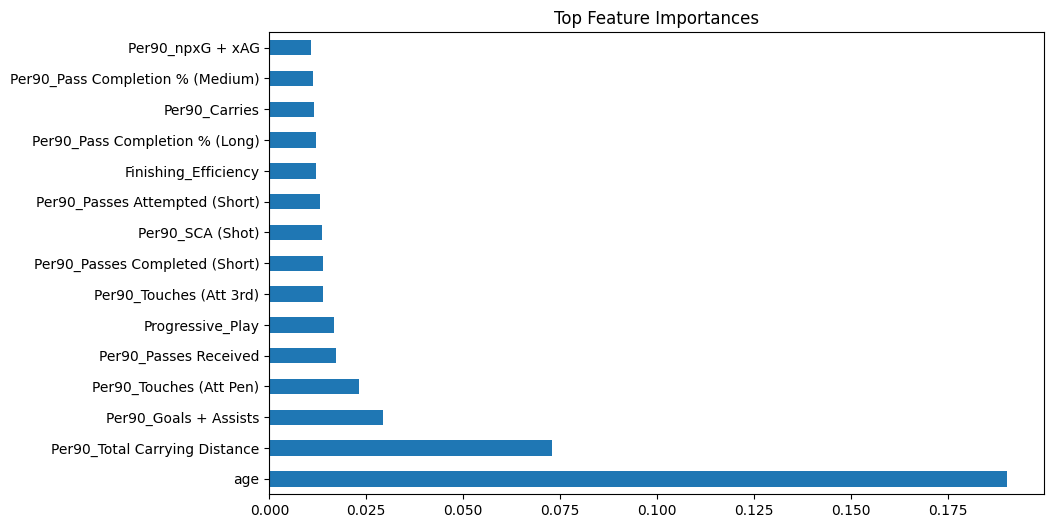

In [146]:
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = outfield_df.drop(columns=["player_market_value_euro", "Player"])  # Features
y = outfield_df["player_market_value_euro"]  # Target

# Train a simple model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(15).plot(kind='barh', figsize=(10, 6), title="Top Feature Importances")
plt.show()

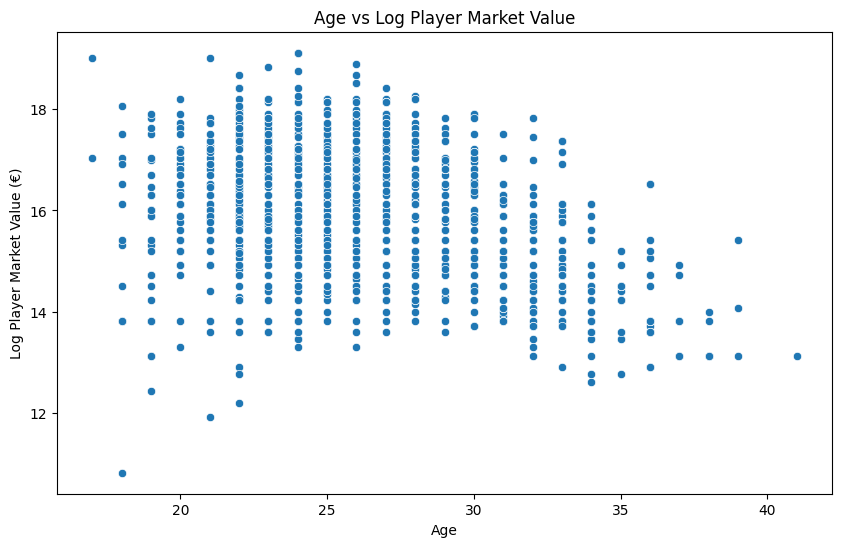

Text(0.5, 1.0, 'Age vs Player Market Value')

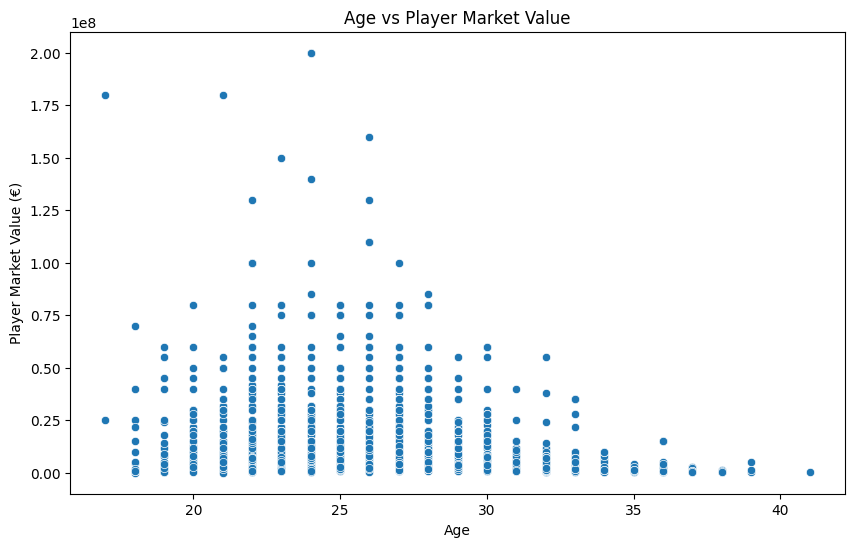

In [147]:
# Visualise age against player_market_value_euro
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outfield_df['age'], y=outfield_df['player_market_value_euro'])
plt.xlabel('Age')
plt.ylabel('Log Player Market Value (€)')
plt.title('Age vs Log Player Market Value')
plt.show()

# Visualise as un-logged valuation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outfield_df['age'], y=np.exp(outfield_df['player_market_value_euro']))
plt.xlabel('Age')
plt.ylabel('Player Market Value (€)')
plt.title('Age vs Player Market Value')

Drop features with low importance and based on domain knowledge

In [148]:
# Identify features to drop (importance < 0.01)
drop_features = feature_importance[feature_importance < FEATURE_IMPORTANT_THRESHOLD].index

# Debugging Step: Print features to be dropped
print(f"Dropping {len(drop_features)} features due to low importance.\n")

# Ensure only numerical columns are dropped in the main dataset
common_columns_to_drop = [col for col in drop_features if col in outfield_df.columns]

# Drop features from both X and outfield_df
X = X.drop(columns=drop_features)
outfield_df = outfield_df.drop(columns=common_columns_to_drop)

print(f"Number of features after dropping non-important features: {X.shape[1]}")

Dropping 43 features due to low importance.

Number of features after dropping non-important features: 73


Standardise numerical features

In [149]:
scaler = StandardScaler()
statistical_cols = [col for col in outfield_df.columns if col not in ['Player', 'player_market_value_euro']]
outfield_df[statistical_cols] = scaler.fit_transform(outfield_df[statistical_cols])

Finding correlation between features 

In [150]:
# Function to compute Cramér's V
def cramers_v(cat_variable, num_variable):
    contingency_table = pd.crosstab(outfield_df[cat_variable], pd.qcut(outfield_df[num_variable], q=4))
    chi2 = chi2_contingency(contingency_table)[0]
    n = outfield_df.shape[0]
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Identify categorical and numerical columns
categorical_cols = []
non_numeric_cols = ["Player", "player_market_value_euro"] + categorical_cols
numerical_cols = outfield_df.select_dtypes(include=["float64", "int64"]).columns

# Drop non-numeric variables before computing numerical correlations
numerical_df = outfield_df.drop(columns=non_numeric_cols, errors="ignore")

# Compute Pearson correlation for numerical variables
numerical_corr_matrix = numerical_df.corr()

# Initialize Cramér’s V matrix for categorical-numerical correlations
cramers_matrix = pd.DataFrame(index=categorical_cols, columns=numerical_cols)

# Compute Cramér's V for categorical-numerical relationships
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        if cat_col != num_col:
            cramers_matrix.loc[cat_col, num_col] = cramers_v(cat_col, num_col)

# Convert Cramér’s V values to float
cramers_matrix = cramers_matrix.astype(float)

# Merge Pearson correlation with Cramér’s V correlation
full_correlation_matrix = numerical_corr_matrix.copy()

for cat_col in categorical_cols:
    for num_col in numerical_cols:
        full_correlation_matrix.loc[cat_col, num_col] = cramers_matrix.loc[cat_col, num_col]

# Convert final matrix to float for heatmap
full_correlation_matrix = full_correlation_matrix.astype(float)


In [151]:
# # Set correlation threshold 
# correlation_threshold = 0.9

# # Compute the absolute correlation matrix
# corr_matrix = full_correlation_matrix.abs()

# # Create a set to hold the features to remove
# features_to_remove = set()

# # Iterate through correlation matrix and identify features to drop
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if corr_matrix.iloc[i, j] > correlation_threshold:  # If correlation is above threshold
#             colname = corr_matrix.columns[i]  # Get feature name
#             features_to_remove.add(colname)  # Add it to the removal list

# # Drop the identified features
# outfield_df_reduced = outfield_df.drop(columns=features_to_remove, errors="ignore")

# # Save the cleaned dataset
# outfield_df_reduced.to_csv("transformed_data/outfield_stats_cleaned.csv", index=False)

# print(f"Removed {len(features_to_remove)} highly correlated features.")
# print(f"Remaining features: {outfield_df_reduced.shape[1]}")
# print(f"Reminding columns: {outfield_df_reduced.columns}")

Dropping highly-correlated data

In [152]:
# top_3_features = ['Player','age', 'Per90_Pass Completion % (Short)', 'Per90_Pass Completion % (Long)', 'Per90_GCA (Live-ball Pass)', 'Per90_Carries', 'Per90_Pass Completion %', 'Finishing_Efficiency']
# outfield_df = outfield_df_reduced[top_3_features]

Reducing Dimension

In [153]:
# # Specify categorical columns to keep
# non_statistical_data = ["Player", "player_market_value_euro"]  

# # Separate categorical and numerical features
# kept_features_df = outfield_df[non_statistical_data].reset_index(drop=True)  # Reset index for safe merge
# features = outfield_df.drop(columns=non_statistical_data)  # Drop categorical columns for PCA

# # Print the number of features before PCA
# print("Number of features before PCA:", features.shape[1])

# # Apply PCA to retain 95% variance
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(features)

# # Convert PCA output back to DataFrame
# pca_df = pd.DataFrame(X_pca, index=outfield_df.index)

# # # Name PCA columns properly
# # pca_df.columns = [f'PCA_{i+1}' for i in range(pca_df.shape[1])]

# # Concatenate categorical columns with PCA-transformed numerical data
# outfield_df = pd.concat([kept_features_df, pca_df.reset_index(drop=True)], axis=1)

# # Print the number of features after PCA
# print("Number of features after PCA:", pca_df.shape[1])

# # Plot PCA explained variance
# plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title("PCA Explained Variance")
# plt.show()

Encoding Categorical Variables (all categorical were dropped as we are manually separating by position)

In [154]:
# print("Columns before encoding:", outfield_df.columns)
# outfield_df = pd.get_dummies(outfield_df, columns=['Versus', 'scouting_period'])
# print("Columns after encoding:", outfield_df.columns)

Others (Removing outliers)

In [155]:
# Save the processed file
outfield_df.to_csv("preprocessed_data/outfield_processed.csv", index=False)
print("Merging completed successfully!")
print(f"Number of rows = ", len(outfield_df))

Merging completed successfully!
Number of rows =  1441


In [156]:
outfield_df.head()

,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,Per90_Carries into Final Third,...,Per90_npxG: Non-Penalty xG,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals,age,player_market_value_euro,Finishing_Efficiency,Assist_Efficiency,Pass_Efficiency,Progressive_Play,Set_Piece_Involvement
0,Aaron Wan-Bissaka,-0.527518,1.126527,-0.556076,-0.755945,-0.264687,1.060108,-0.153949,-0.318241,0.766689,...,-0.572956,-0.447260,-0.584082,0.164877,16.906553,0.098499,-0.294656,0.175392,0.774498,-0.789245
1,Aarón Martín,-0.496038,0.954536,-0.347470,-0.632268,1.302512,-0.031094,0.189566,-0.704704,-0.366742,...,-0.714247,0.918885,-0.709329,0.164877,15.424948,-0.080403,-0.311118,-0.913562,-0.533443,2.753988
2,Abakar Sylla,0.788366,2.095406,0.069741,0.699645,-1.477401,-0.164551,1.413342,0.955141,-1.341736,...,-0.643602,-1.130332,-0.646705,-1.032643,16.300417,0.072942,-0.706204,1.118958,-1.465244,0.616388
3,Abdallah Sima,0.184033,0.811631,2.001188,1.753514,-0.666664,0.684740,-1.167309,-0.851305,0.055958,...,1.561525,-0.092369,1.308027,-0.793139,16.118096,0.896075,0.397561,-1.647391,-0.379969,-0.911160
4,Abde Ezzalzouli,-0.458261,0.232176,0.399119,-0.194639,-0.208716,0.659739,-0.153949,0.127536,3.057926,...,1.687692,0.008122,1.670361,-0.793139,16.523561,-0.097132,-0.267219,-1.120399,1.539601,-0.802200
